In [1]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions

In [2]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,cte::Float64=0.0) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0    #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck
    
    for i=1:length(t)                 #Usamos un for para poder hacer el proceso
        x0=x0-(x0*γ)+randn()+cte*γ # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x                          # Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 2 methods)

In [3]:
function eigen2(n::Int64,K::Array{Float64,1},Δt::Float64) #Obtenemos los eigenvalores y eigenvectores 
    R=diagm(0 =>ones(2))                                #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n                                           #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(2))+diagm(1 => [K[i]]*Δt,-1 => -[K[i]]*Δt)+(0.5*diagm(1 => [K[i]]*Δt,-1 => -[K[i]]*Δt)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R)#Obtenemos el eigenvalor y eigenvector
end

function eigen2(n::Int64,K::Array{Float64,1},T::Array{Float64,1},Δt::Float64) 
    R=diagm(0 =>ones(3)) #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n            #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(3))+diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)+(0.5*diagm(1 => [K[i],T[i]]*Δt,-1 => -[K[i],T[i]]*Δt)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R) #Obtenemos el eigenvalor y eigenvector
end

eigen2 (generic function with 2 methods)

In [4]:
function lam_eigenvals(γ::Float64,Δt::Float64,t::AbstractArray,tiradas::Int64,k0::Float64) #Da una lista de eigenvalores de todas las tiradas
    λ=Vector{Complex{Float64}}(undef,2*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas             #Un for con la cantidad de tiradas
        K=OUH(k0,γ,t,Δt)        #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),K,Δt).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[2*i-1]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[2*i-0]=a[2] #Reescribirmos la basura con los eigenvalores
    end
    return λ   #Devolvemos la lista de eigenvalores
end

function lam_eigenvals(γ::Float64,Δt::Float64,t::AbstractArray,tiradas::Int64,k0::Float64,t0::Float64)
    λ=Vector{Complex{Float64}}(undef,3*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas #Un for con la cantidad de tiradas
        K=OUH(k0,γ,t,Δt) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        T=OUH(t0,γ,t,Δt) #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),K,T,Δt).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[3*i-2]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-1]=a[2] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[3*i-0]=a[3] #Reescribirmos la basura con los eigenvalores
    end
    return λ
end

lam_eigenvals (generic function with 2 methods)

In [5]:
function lam_eigenvals_C(λ::Array{Complex{Float64},1})
    λr=Complex{Float64}[]
    for i=1:length(λ)
        if imag(λ[i]) != 0
            push!(λr,λ[i])
        end
    end
    return λr
end
function lam_eigenvals_R(λ::Array{Complex{Float64},1})
    λr=Float64[]
    for i=1:length(λ)
        if imag(λ[i]) == 0
            push!(λr,λ[i])
        end
    end
    return λr
end

lam_eigenvals_R (generic function with 1 method)

In [20]:
γ=1e0
tiradas=500
k0=0.0
t0=k0
Δt=0.001
N=100.0
t=0:Δt:N
Δs=Δt
step=100 #Para animar

cte=0.0
plot(t,OUH(k0,γ,t,Δt),legend=false,ylims=(-100,100))
plot!(t,ones(length(t))*cte)

length(1:step:length(t))

1001

In [21]:
@time λ_2=lam_eigenvals(γ,Δt,t,tiradas,k0);


174.719486 seconds (2.55 G allocations: 124.800 GiB, 11.06% gc time)


In [22]:
@time λ_3=lam_eigenvals(γ,Δt,t,tiradas,k0,t0);

197.430443 seconds (3.15 G allocations: 150.506 GiB, 9.64% gc time)


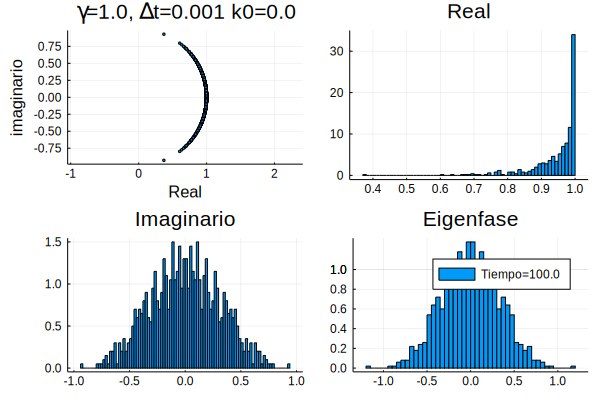

In [23]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_2),imag(λ_2),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0)")
Q2=histogram(real(λ_2),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_2),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_2),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_2D_gam=$(γ)_k0=$(k0).png")

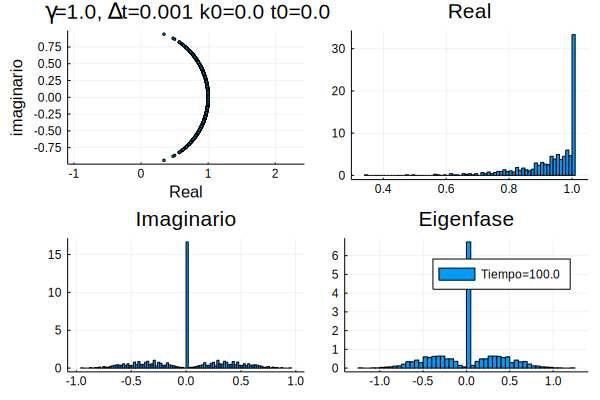

In [24]:

l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3),imag(λ_3),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_gam=$(γ)_k0=$(k0)_t0=$(t0).png")

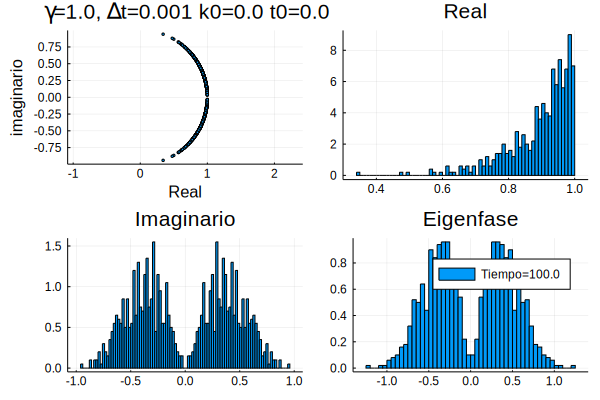

In [25]:
λ_3_C=lam_eigenvals_C(λ_3)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3_C),imag(λ_3_C),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3_C),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3_C),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3_C),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l)
#savefig("Eigenvalores_Completo_3D_Complejo_gam=$(γ)_k0=$(k0)_t0=$(t0).png")

In [12]:
λ_3_R=lam_eigenvals_R(λ_3)
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ_3_R),imag(λ_3_R),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)")
Q2=histogram(real(λ_3_R),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ_3_R),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(angle.(λ_3_R),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
plot(Q1,Q2,Q3,Q4,layout=l);
savefig("Eigenvalores_Completo_3D_Reales_gam=$(γ)_k0=$(k0)_t0=$(t0).png")

In [ ]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals(γ,Δt,t[1:j],tiradas,k0);
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0)",xlims=(-1.1,1.1),ylims=(-1.1,1.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_2D_k0=$(k0).gif", fps=120)
end

In [ ]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals_C(lam_eigenvals(γ,Δt,t[1:j],tiradas,k0,t0));
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) k0=$(k0) t0=$(t0)",xlims=(-1.1,1.1),ylims=(-1.1,1.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_3D_gam=$(γ)_k0=$(k0)_t0=$(t0)_no_reals.gif", fps=120)
end